***
# Constants and functions
***

In [1]:
import numpy as np
from scipy.signal import convolve,savgol_filter,find_peaks
from scipy.fft import fft, fftfreq, ifft
from scipy.integrate import simpson
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

np.set_printoptions(suppress=True)

SMALL_SIZE = 35
MEDIUM_SIZE = 40
BIGGER_SIZE = 45

plt.rcParams['figure.figsize'] = (16.18, 10)
plt.rc('lines', linewidth=4.5)

if False: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{textcomp,amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
    plt.rcParams["font.family"] = "Computer Modern Roman"

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def splitter(x,lim):
    """Splits data into peaks. x is the list of points above some thresold."""
    N = 1  #number of splits
    diffs = np.diff(x)
    for i in diffs:
        if i>lim: N += 1
    temp = [[] for n in range(N)]
    
    tempN = 0
    for i in range(len(x)-1):
        if diffs[i]<=lim:
            temp[tempN].append(x[i])
        else:
            temp[tempN].append(x[i])
            tempN += 1
    filtered = temp.copy()
    for i in temp:
        if len(i) <= 3: filtered.remove(i)
    return filtered

def ampgauss(x,amp,a,s):
    return amp*np.exp(-(x-a)**2/2/s**2)

def gauss(x,a,s):
    return 1/(np.sqrt(2*np.pi)*s)*np.exp(-(x-a)**2/2/s**2)

def cos(x,a,f,s):
    return s+a*np.cos(x*f)

def BG(x,a,f):
    return 1+a*(np.cos(np.sqrt(x)*f)-1)

def line(x,a,b):
    return a*x+b

def quad(x,a,b):
    return 1-a*x**2-b*x

def exp_sum(x,amps,avs,sigs):
    return np.sum([amps[i]*np.exp(-(x-avs[i])**2/2/sigs[i]**2) for i in range(len(avs))],axis=0)

def asyg(t,amp,av,sig,a):
    scale = sig/(1+np.exp(a*(t-av)))
    return amp*np.exp(-(t-av)**2/(2*scale**2))

G = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
M = 1.674927e-27    #mass of neutron (kg)
HBAR = 1.054571e-34    #plancks constant (kg m^2/s)
H = HBAR*2*np.pi
CL = G/(HBAR*2*np.pi)*M    #Larmor phase constant (T^-1 m^-1 AA^-1)

def get_BG_freq(temp_freq,deg,p=True):
    spc = 2*1.67e-27*temp_freq*1e6*1.2/6.626e-34/np.tan(deg/180*np.pi)*1e-10 #per Angstrom
    global sld 
    sld = 2.06e-6  #per Angstrom squared
    global d 
    d = 10.5*1e4  #groove depth in Angstroms
    tc = sld*d/np.sqrt(spc)  #'that constant'
    if p:
        print(f'a = {round(spc)} A^-1 at rf freq {temp_freq} MHz')
        print(f'Cosine freq {round(tc*1e2,5)} um^(-1/2) \n')
    return spc,tc

_ = get_BG_freq(2,40)
_ = get_BG_freq(3,40)

home_path = "C:\\Users\\samck\\Documents\\GitHub\\SESANS-coherence-length\\Processed data\\"
work_path = "C:\\Users\\xsm\\Documents\\GitHub\\SESANS-coherence-length\\Processed data\\"

rob_2MHz = 1e4*np.polyval([7.42468285310946e-09, -2.37424465512104e-6, 2.92814364848172e-04,
                       -1.85712645099827e-02, 5.44463590018381e-01], 40.)
rob_3MHz = rob_2MHz*1.5

print(f'Rob\'s 2MHz calibration: a = {round(rob_2MHz)} A^-1')
print(f'Cosine freq {round(Rob_2 := sld*d/np.sqrt(rob_2MHz)*1e2,5)} um^(-1/2) \n')
print(f'Rob\'s 3MHz calibration: a = {round(rob_3MHz)} A^-1')
print(f'Cosine freq {round(Rob_3 := sld*d/np.sqrt(rob_3MHz)*1e2,5)} um^(-1/2) \n')

a = 1442 A^-1 at rf freq 2 MHz
Cosine freq 0.56965 um^(-1/2) 

a = 2163 A^-1 at rf freq 3 MHz
Cosine freq 0.46512 um^(-1/2) 

Rob's 2MHz calibration: a = 1372 A^-1
Cosine freq 0.58402 um^(-1/2) 

Rob's 3MHz calibration: a = 2058 A^-1
Cosine freq 0.47685 um^(-1/2) 



## Wavepacket spread

Flight time = 10.111 (ms)


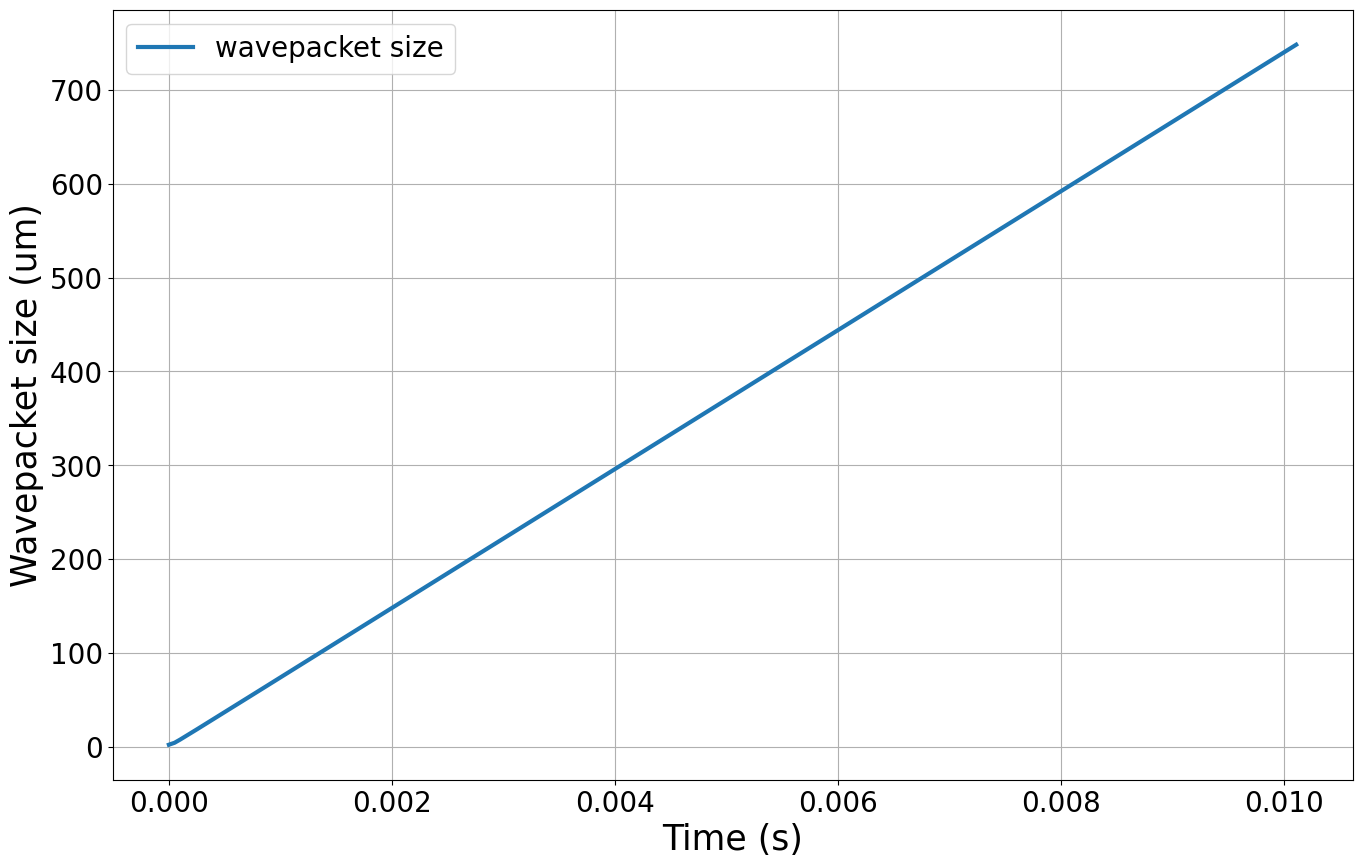

In [3]:
def wp_spread(t,a):
    """Wavepacket spread from gaussian."""
    return a*np.sqrt(1 + (HBAR*t/M/a**2/2)**2)

def get_v(l):
    """Converts wavelength in Angstroms to velocity in m/s."""
    return H/M/l*1e10

L = 10
a0 = 1e-6  #initial wavepacket standard deviation
beam = .01  #beam diameter
time = np.linspace(0,L/get_v(4),200)
print(f'Flight time = {round(time[-1]*1e3,3)} (ms)')

fig,ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
plt.plot(time,2.35*wp_spread(time,a0)*1e6,label='wavepacket size')
#plt.plot(time,np.full(len(time),beam)*1e6,label='beam size')
plt.ylabel('Wavepacket size (um)')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

## Moderator contribution

linear fit and error: [0.00104927 0.00336409],[0.0000054  0.00004562] 



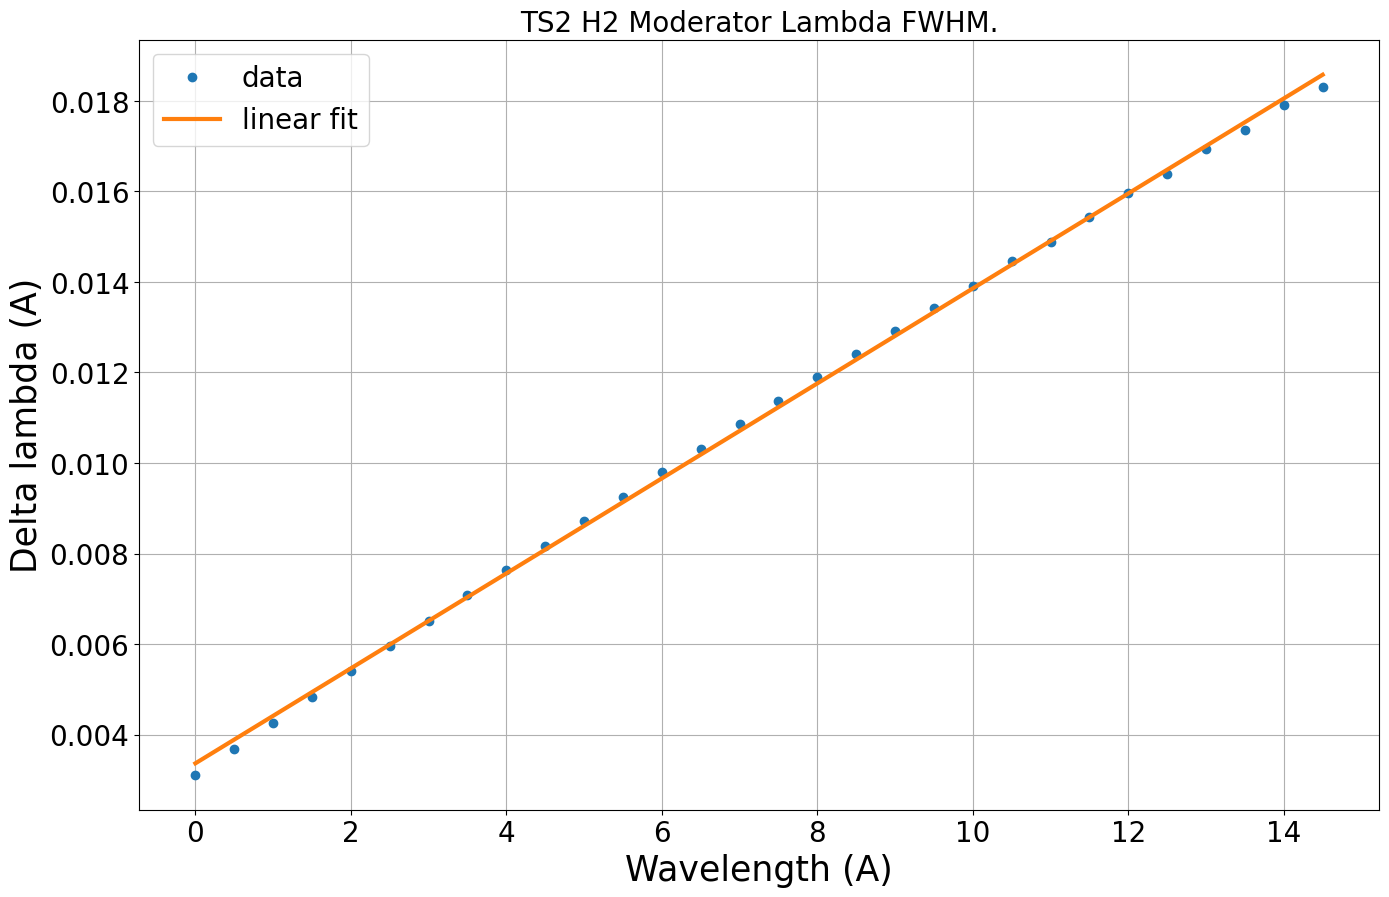

In [4]:
mpath = "C:\\Users\\samck\\Desktop\\"
mmod = "ModeratorStdDev_TS2_SANS_LETexptl_07Aug2015.txt"

with open(mpath+mmod) as file:
    lines = csv.reader(file, delimiter='\t')
    x,y = [],[]
    for row in lines:
        x.append(float(row[0]))
        y.append(float(row[1]))
    x,y = np.copy(x)[:len(x)//2],np.copy(y)[:len(x)//2]

dl = 6.626e-34/1.62e-27/29.7*y*1e10*1e-6  #check this with the Robs

plt.title('TS2 H2 Moderator Lambda FWHM.')
plt.plot(x,dl,'o',label='data')

mlin,mlinerr = curve_fit(line,x,dl)
print(f'linear fit and error: {mlin},{np.sqrt(np.diag(mlinerr))} \n')
plt.plot(x,line(x,*mlin),label='linear fit')

"""mq,mqerr = curve_fit(mod_quad,x,dl)
print(f'quadratic fit and error: {mq},{np.sqrt(np.diag(mqerr))} \n')
plt.plot(x,mod_quad(x,*mq),label='quad fit')"""

plt.xlabel('Wavelength (A)')
plt.ylabel('Delta lambda (A)')

plt.legend()
plt.grid()
plt.show()

***
# 90 deg data 2MHz
***

a = 1442 A^-1 at rf freq 2 MHz
Cosine freq 0.56965 um^(-1/2) 



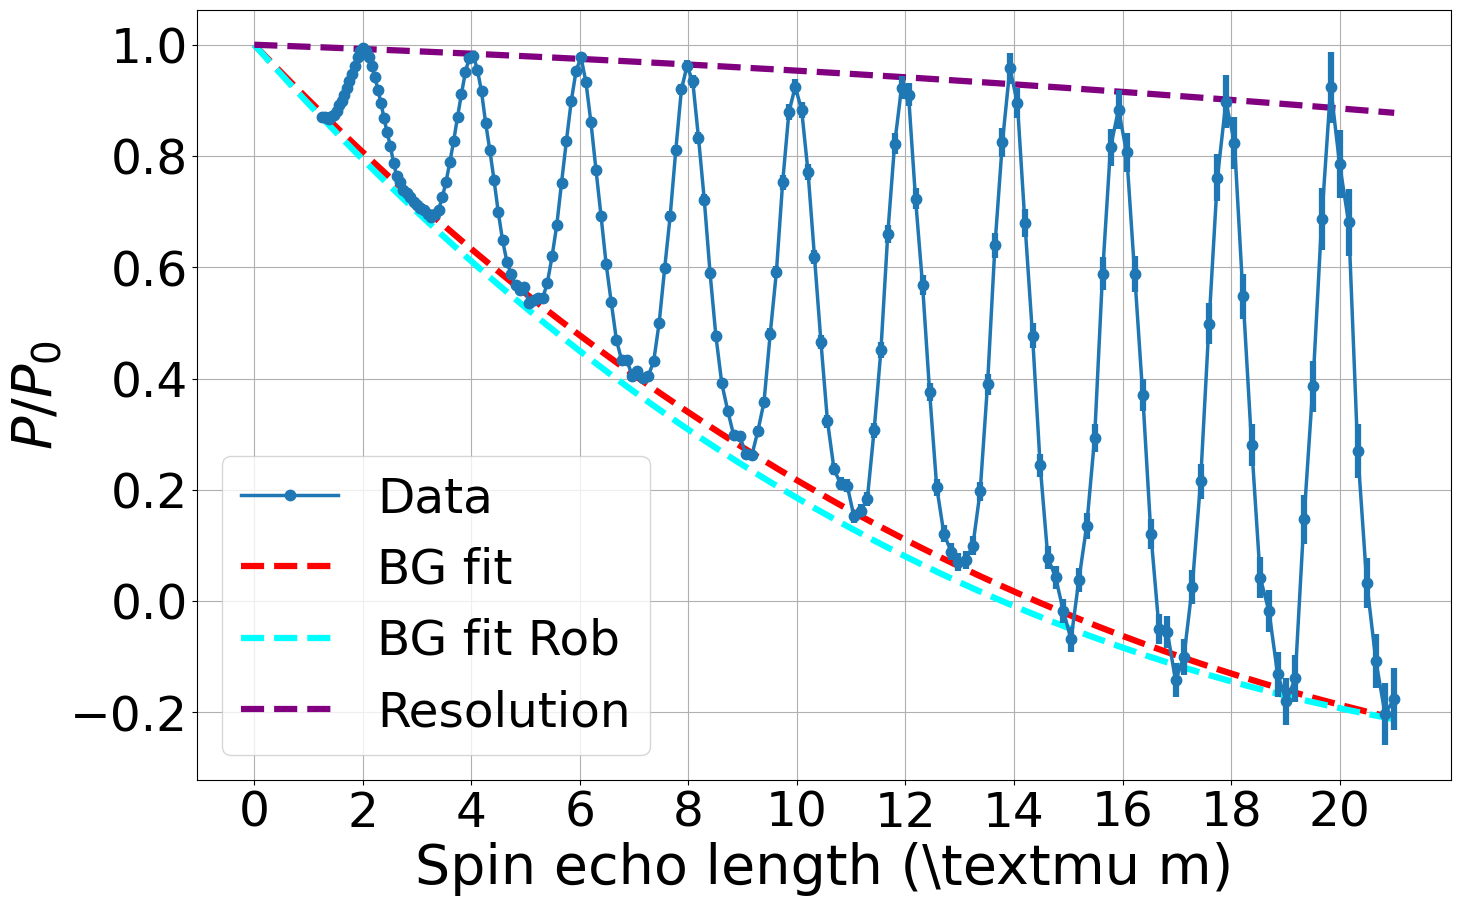

BG fit: 1 + amp*(cos(sqrt(freq)) - 1), [amp,freq]=[0.664   0.55356]
	 Errs: [0.0194  0.01013]
Peak fit: 1-a*x**2-b*x: [a,b]=[0.00016 0.00416]
	 Errs: [0.00008 0.00078]
--------------------------------------------------

Fitted peak 0: [amp,av,sig]=[0.199 2.062 0.303]
	 Errors: [0.00128 0.0024  0.00333]
Fitted peak 1: [amp,av,sig]=[0.366 4.036 0.315]
	 Errors: [0.00239 0.0024  0.00279]
Fitted peak 2: [amp,av,sig]=[0.514 6.023 0.323]
	 Errors: [0.00434 0.00316 0.00346]
Fitted peak 3: [amp,av,sig]=[0.644 8.006 0.326]
	 Errors: [0.00628 0.00365 0.0038 ]
Fitted peak 4: [amp,av,sig]=[0.737 9.992 0.334]
	 Errors: [0.00434 0.00226 0.00234]
Fitted peak 5: [amp,av,sig]=[ 0.845 11.975  0.327]
	 Errors: [0.01021 0.00456 0.005  ]
Fitted peak 6: [amp,av,sig]=[ 0.956 13.957  0.328]
	 Errors: [0.01217 0.00482 0.00489]
Fitted peak 7: [amp,av,sig]=[ 0.975 15.942  0.339]
	 Errors: [0.0138  0.00554 0.00586]
Fitted peak 8: [amp,av,sig]=[ 1.037 17.933  0.337]
	 Errors: [0.01752 0.00656 0.00678]
Fitted peak 

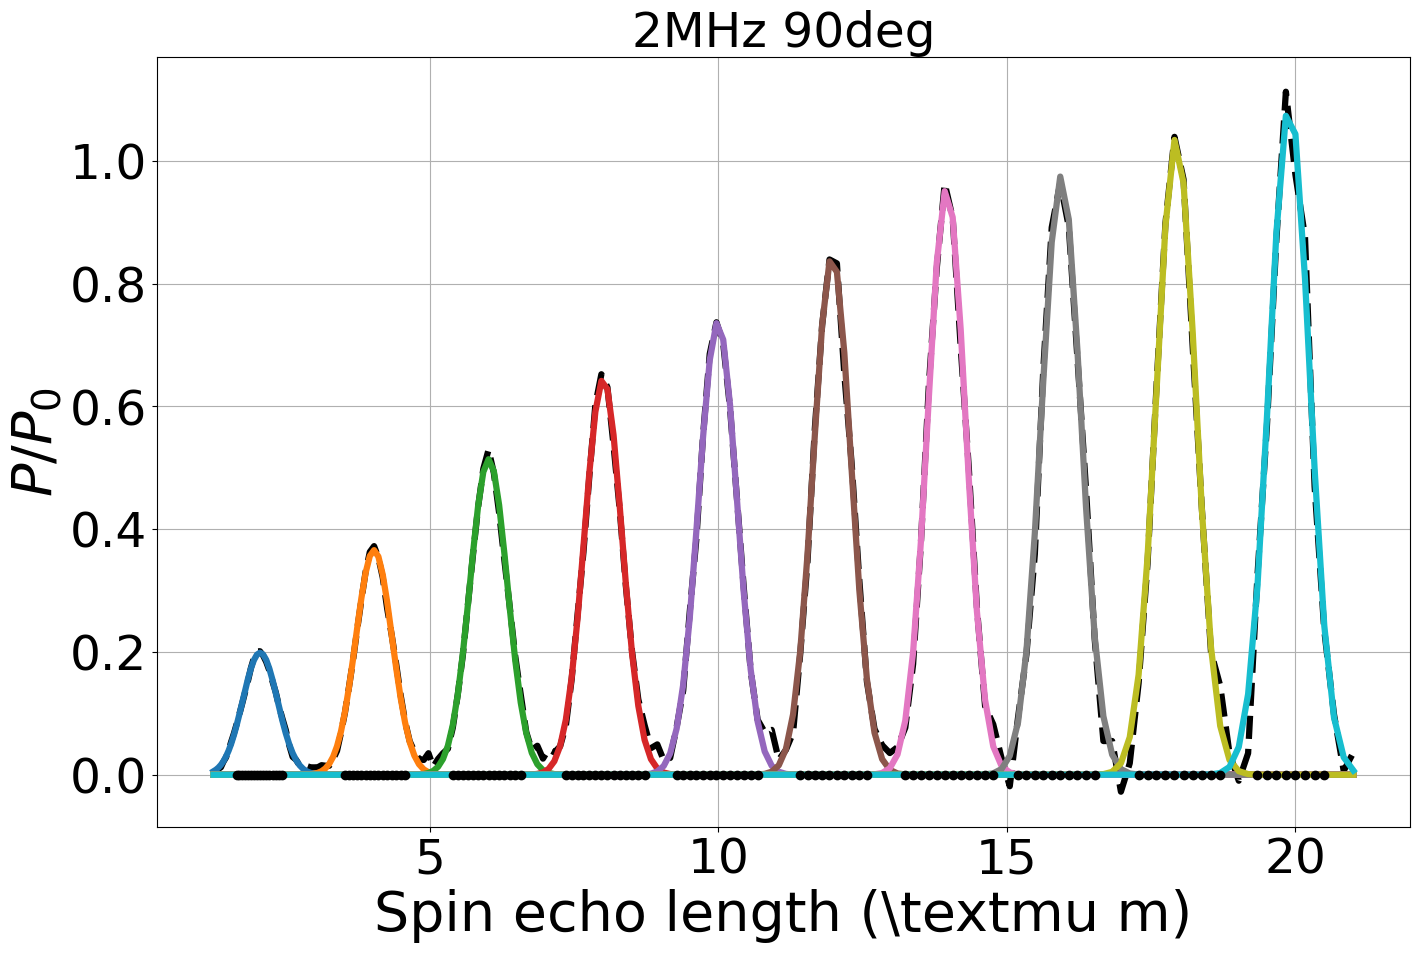

In [24]:
path = work_path
file = "pols_2Mhz_90deg3.0_0.05_12.5.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-2]  #-2 to include last peak, -26 otherwise
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)
    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])
    
    s = savgol_filter(y,5,3)
    tr,_ = find_peaks(-s,distance=1)
    pk,_ = find_peaks(s,distance=1)
    pk = pk[1:]  #remove false peaks

fig, ax = plt.subplots()
plt.plot(x,y,'o',label='Data',color='C0',ms=7.5,zorder=5,ls='-',linewidth=2.5)
plt.errorbar(x,y,e,color='C0',ls='none',zorder=5)
#plt.plot(x,s,'-',label='Data smoothed',color='C1')
#plt.plot(x[tr],s[tr],'o',ms=10,color='red',zorder=10)
#plt.plot(x[pk],s[pk],'o',ms=10,color='green',zorder=10)

guess_tr = [.65,get_BG_freq(2,40)[1]]
parms_tr,err_tr = curve_fit(BG,x[tr],s[tr],p0=guess_tr,sigma=e[tr])
guess_pk = [0,0]  #quad fit
parms_pk,err_pk = curve_fit(quad,x[pk],s[pk],sigma=e[pk])

plt.plot(x_tot,BG(x_tot,*parms_tr),'--',color='red',label='BG fit')
#plt.plot(x_tot,BG(x_tot,*BG_parms_2_8),'--',color='magenta',label='BG fit from 8 deg')
plt.plot(x_tot,BG(x_tot,*[.64,Rob_2]),'--',color='cyan',label='BG fit Rob')
#plt.plot(x_tot,quad(x_tot,*parms_pk),'--',color='green',label='Peak fit')
plt.plot(x_tot,np.ones(len(x_tot))-.0036*x_tot-.000106*x_tot**2,'--',color='purple',label='Resolution')

#plt.title('2MHz 90deg')
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
plt.xlabel(r'Spin echo length (\textmu m)')
plt.ylabel(r'$P/P_0$')
ax.set_xticks(range(0,21,2))
plt.grid()
plt.show()

print(f'BG fit: 1 + amp*(cos(sqrt(freq)) - 1), [amp,freq]={np.round(parms_tr,5)}')
print(f'\t Errs: {np.round(np.sqrt(np.diag(err_tr)),5)}')
print(f'Peak fit: 1-a*x**2-b*x: [a,b]={np.round(parms_pk,5)}')
print(f'\t Errs: {np.round(np.sqrt(np.diag(err_pk)),5)}')
print('-'*50 + '\n')

fig, ax = plt.subplots()
#subtracted = y-BG(x,*parms_tr)
#subtracted = y-BG(x,*BG_parms_2_8)
subtracted = y-BG(x,*[.64,Rob_2])
peak_x = np.where(subtracted>0.075)
plt.plot(x,subtracted,'--',color='black')

#Symmetric peak fitting
seperated = splitter(peak_x[0],1)
fparms = []
all_errs = []

for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [.5,x[sep[len(sep)//2]],.4]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    all_errs.append(errs)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(errs)),5)}')

plt.title('2MHz 90deg')
plt.xlabel(r'Spin echo length (\textmu m)')
plt.ylabel(r'$P/P_0$')
plt.grid()
plt.show()

X_saved = np.copy(x)
X_tot_saved = np.copy(x_tot)
S_saved = np.copy(s)
fparms_saved = np.copy(fparms)
BG_parms_2_90 = np.copy(parms_tr)

In [44]:
if False:
    #Asymmetric peak fitting, doesn't seem to work well
    fig, ax = plt.subplots()
    plt.xlabel('Spin echo length (um)')
    plt.ylabel('P/P_0')
    ax.set_xticks(range(0,21,2))
    plt.grid()

    plt.plot(x,subtracted,'--',color='black')
    #uses same peaks found in symmetric fitting section

    fparms = []
    for indx,sep in enumerate(seperated):
        plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
        guess = [.5,x[sep[indx]],.7,-.1]
        ffa,aerrs = curve_fit(asyg,x[sep],subtracted[sep],p0=guess)
        #plt.plot(x,asyg(x,*guess),'--',color=f'C{indx}')
        plt.plot(x,asyg(x,*ffa),color=f'C{indx}')
    
        print(f'Fitted peak {indx}: [amp,av,sig,a]={np.round(ffa,3)}')
        print(f'\t Errors: {np.round(np.sqrt(np.diag(aerrs)),5)}')
    
    plt.show()

***
# 8 deg data 2 MHz
***

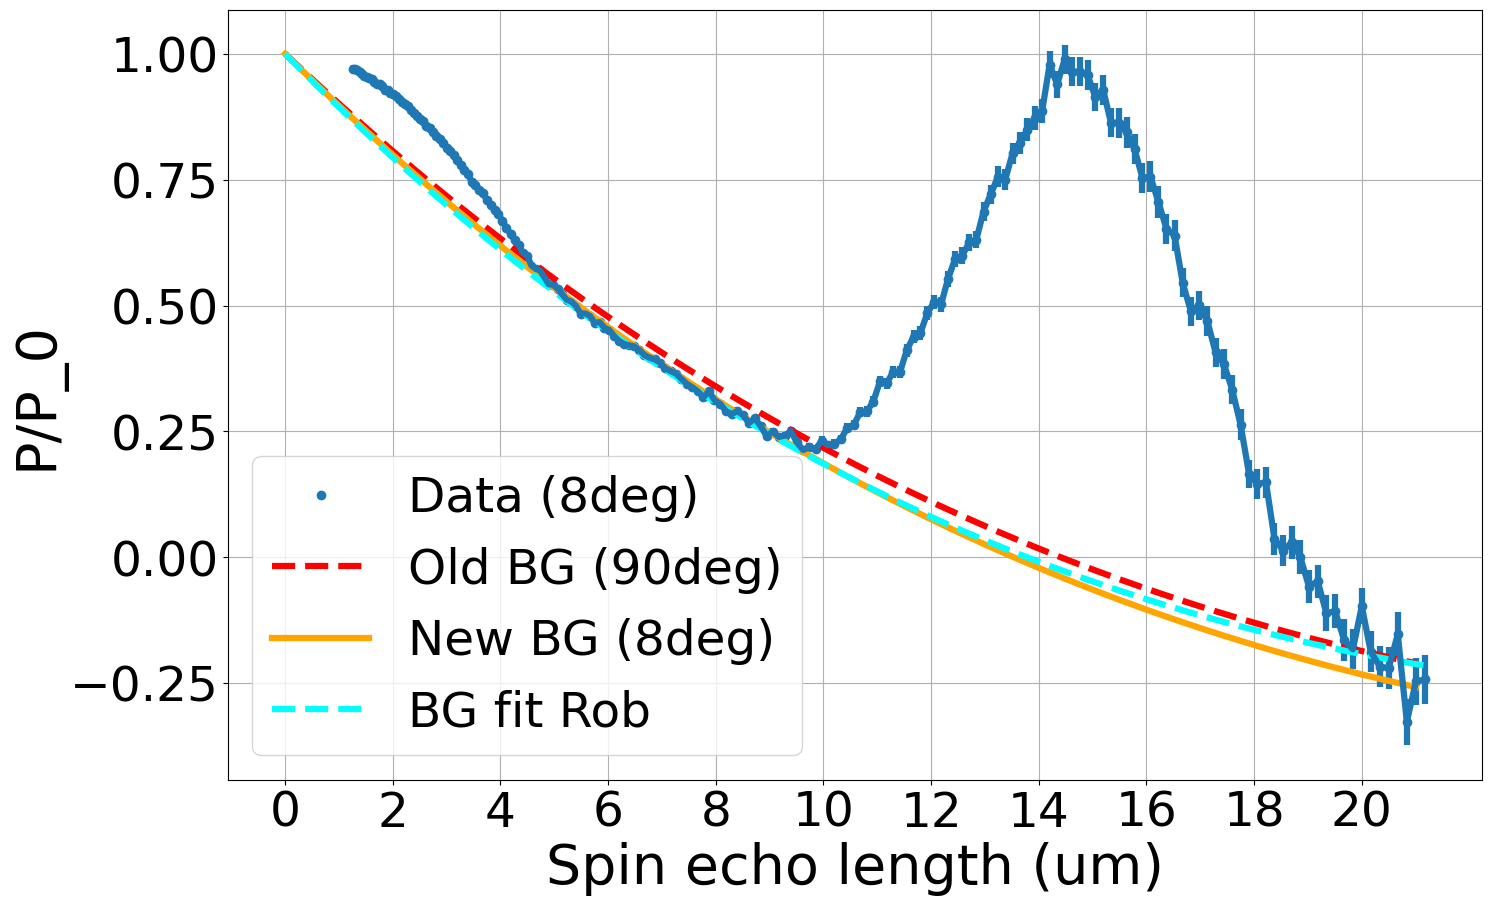

Old Background: [0.664   0.55356]
New Background: [0.69    0.55356]
--------------------------------------------------

Fitted peak 0: [amp,av,sig]=[0.123 2.221 1.449]
	 Errors: [0.00038 0.00863 0.01379]
Fitted peak 1: [amp,av,sig]=[ 0.999 14.896  2.144]
	 Errors: [0.00586 0.01448 0.01501]


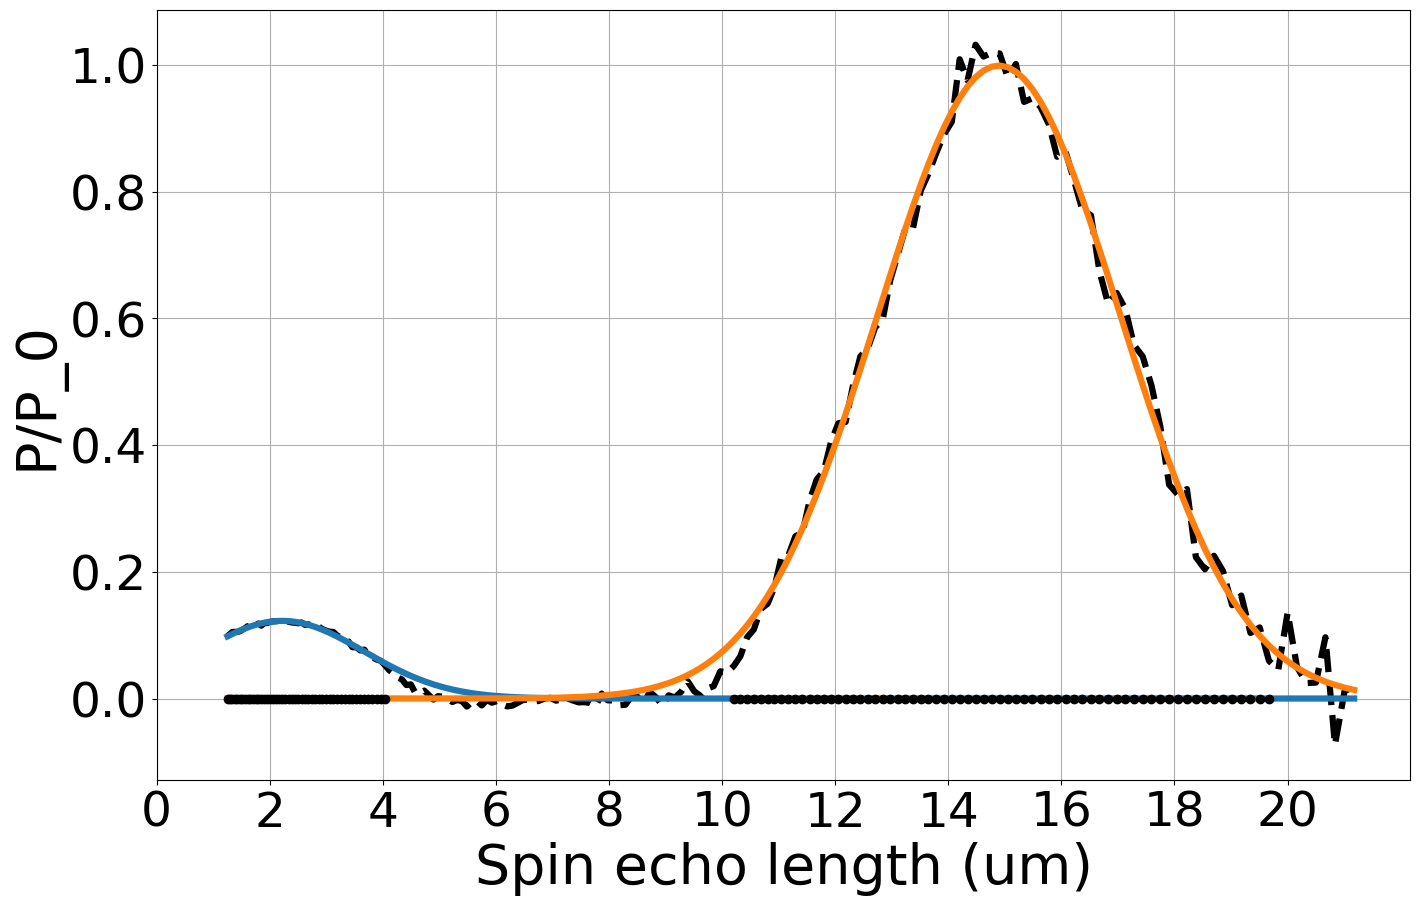

In [19]:
path = work_path
file = "pols_2Mhz_8deg3.0_0.05_12.5.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-1]
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)
    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])
    
    s = savgol_filter(y,5,3)
    
fig, ax = plt.subplots()
plt.plot(x,y,'o',label='Data (8deg)',color='C0')
plt.errorbar(x,y,e,color='C0')
#plt.plot(X_saved,S_saved,'-',label='Smoothed (90deg)',color='C1')

plt.plot(X_tot_saved,BG(X_tot_saved,*BG_parms_2_90),'--',color='red',label='Old BG (90deg)')
bs = [0.69, BG_parms_2_90[1]]  #total guess for the fit
plt.plot(X_tot_saved,BG(X_tot_saved,*bs),color='orange',label='New BG (8deg)')

plt.plot(x_tot,BG(x_tot,*[.64,Rob_2]),'--',color='cyan',label='BG fit Rob')

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
ax.set_xticks(range(0,21,2))
plt.grid()
ax.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print(f'Old Background: {np.round(parms_tr,5)}')
print(f'New Background: {np.round(bs,5)}')
print('-'*50 + '\n')

#Symmetric peak fitting
fig, ax = plt.subplots()
subtracted = y-BG(x,*bs)
peak_x = np.where(abs(subtracted)>0.05)
plt.plot(x,subtracted,'--',color='black')

seperated = splitter(peak_x[0],1)

fparms = []
for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [.5,x[sep[len(sep)//2]],3]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(errs)),5)}')
fparms = np.array(fparms)

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
ax.set_xticks(range(0,21,2))
plt.grid()
plt.show()

X2_saved = np.copy(x)
X2_tot_saved = np.copy(x_tot)
S2_saved = np.copy(s)
fparms2_saved = np.copy(fparms)
BG_parms_2_8 = np.copy(bs)

In [4]:
if False:
    #Asymmetric peak fitting, doesn't seem to work well
    fig, ax = plt.subplots()
    plt.xlabel('Spin echo length (um)')
    plt.ylabel('P/P_0')
    ax.set_xticks(range(0,21,2))
    plt.grid()

    plt.plot(x,subtracted,'--',color='black')
    #uses same peaks found in symmetric fitting section

    fparms = []
    for indx,sep in enumerate(seperated):
        plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
        guess = [1,x[sep[indx]],3,-1]
        ffa,aerrs = curve_fit(asyg,x[sep],subtracted[sep],p0=guess)
        #plt.plot(x,asyg(x,*guess),'--',color=f'C{indx}')
        plt.plot(x,asyg(x,*ffa),color=f'C{indx}')
    
        print(f'Fitted peak {indx}: [amp,av,sig,a]={np.round(ffa,3)}')
        print(f'\t Errors: {np.round(np.sqrt(np.diag(aerrs)),5)}')
    
    plt.show()

***
# 8deg data 3 MHz
***

New BG function: [0.69    0.45198]


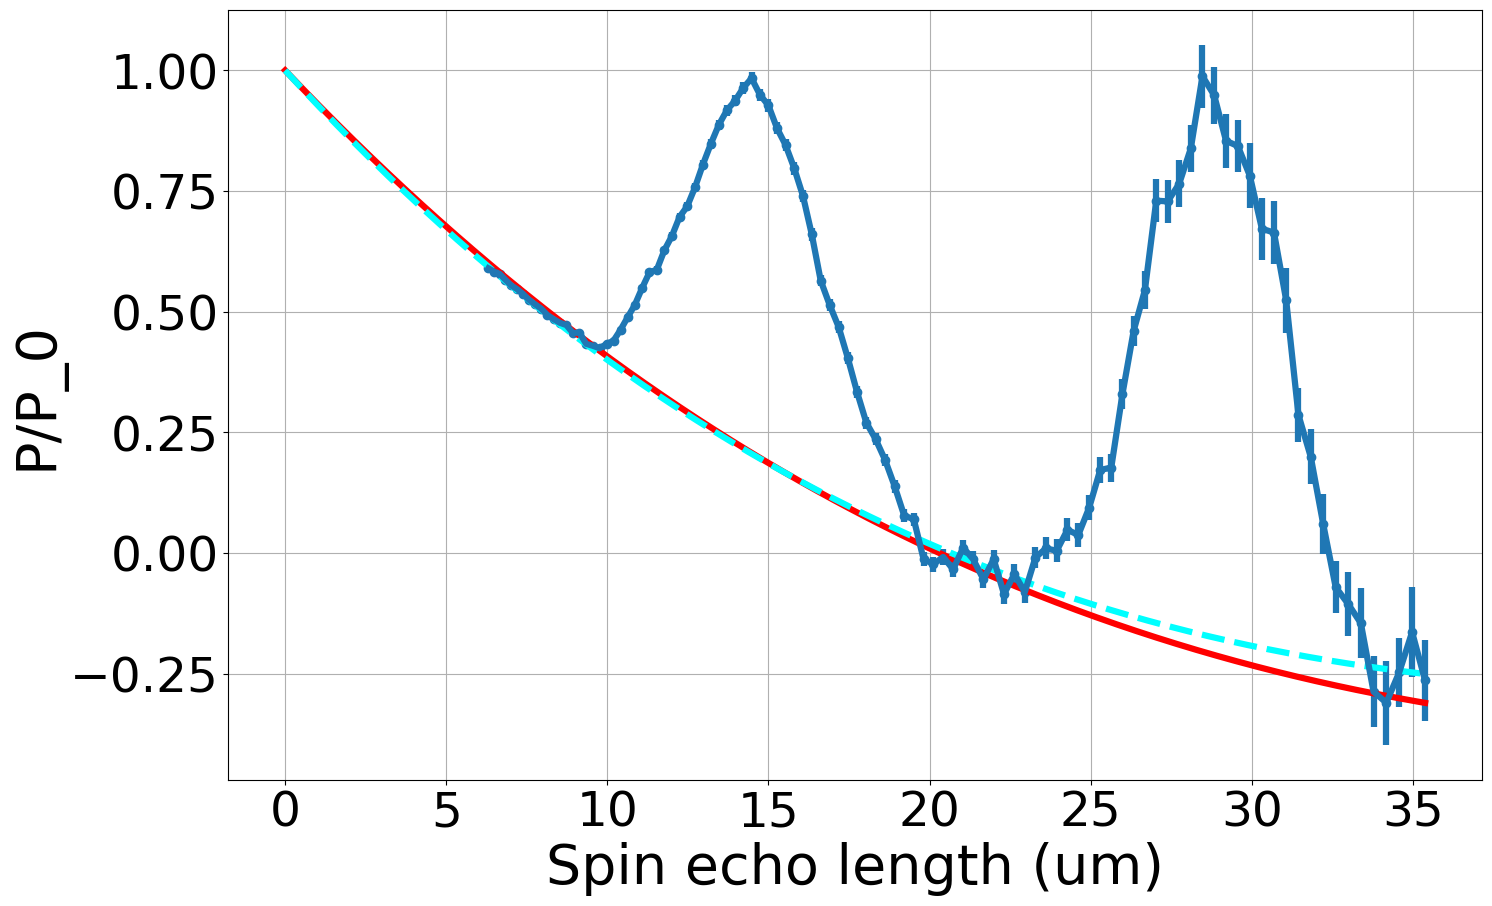

Fitted peak 0: [amp,av,sig]=[ 0.749 14.627  2.081]
	 Errors 0: [0.00494 0.01579 0.01632]
Fitted peak 1: [amp,av,sig]=[ 1.149 28.862  2.196]
	 Errors 1: [0.01732 0.03821 0.03928]


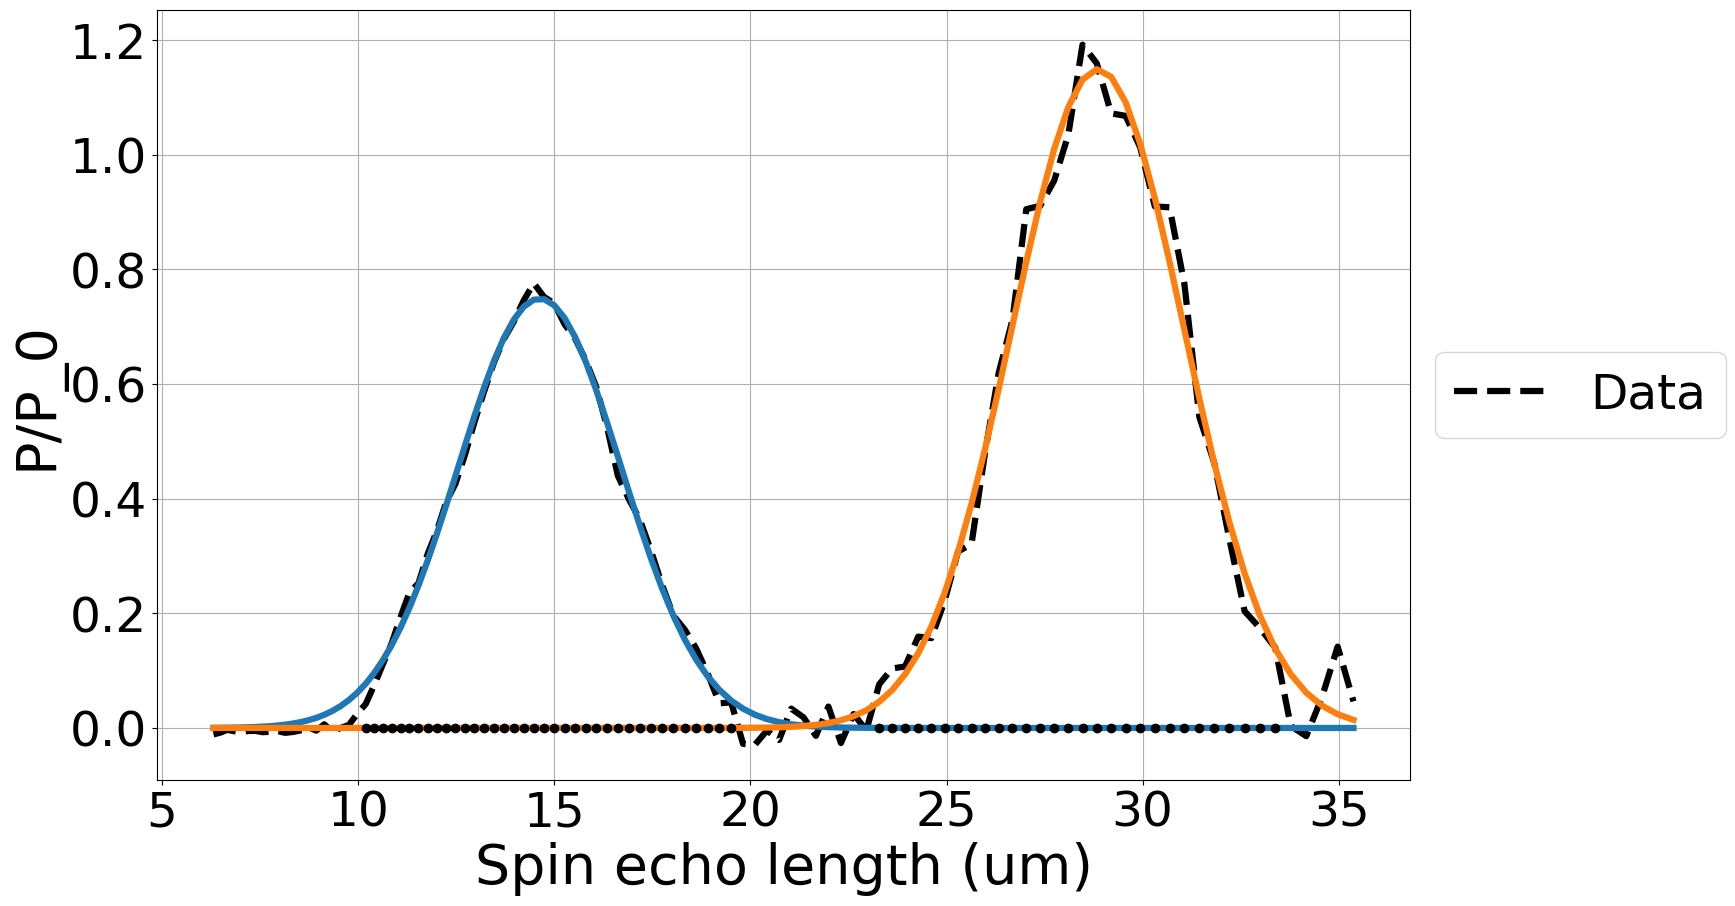

In [11]:
path = work_path
#file = "pols_3Mhz_8deg5.5_0.1_13.25.dat"
file = "pols_3Mhz_8deg5.5_0.075_13.25.dat"
#file = "pols_3Mhz_8deg5.5_0.05_13.25.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-2]
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)
    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])

    s = savgol_filter(y,6,3)

fig, ax = plt.subplots()
plt.plot(x,y,'o',label='Data raw',color='C0')
plt.errorbar(x,y,e,color='C0')
#plt.plot(X_saved,S_saved,'--',label='2Mhz,90deg',color='C1')
#plt.plot(X2_saved,S2_saved,'--',label='2MHz,8deg',color='C2')

bs = [0.69,BG_parms_2_90[1]*np.sqrt(2/3)]  #total guess for the fit
plt.plot(x_tot,BG(x_tot,*bs),color='red',label='BG (8deg,3 MHz)')
print(f'New BG function: {np.round(bs,5)}')

plt.plot(x_tot,BG(x_tot,*[.64,Rob_3]),'--',color='cyan',label='BG fit Rob')

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
plt.grid()
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig, ax = plt.subplots()
subtracted = y-BG(x,*bs)
peak_x = np.where(subtracted>0.025)
plt.plot(x,subtracted,'--',color='black',label='Data')

seperated = splitter(peak_x[0],1)

fparms = []
for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [.5,x[sep[len(sep)//2]],3]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors {indx}: {np.round(np.sqrt(np.diag(errs)),5)}')
fparms = np.array(fparms)

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
plt.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

X3_saved = np.copy(x)
X3_tot_saved = np.copy(x_tot)
S3_saved = np.copy(s)
fparms3_saved = np.copy(fparms)
BG_parms_3_8 = np.copy(bs)

***
# 4.5 deg at 3 MHz
***

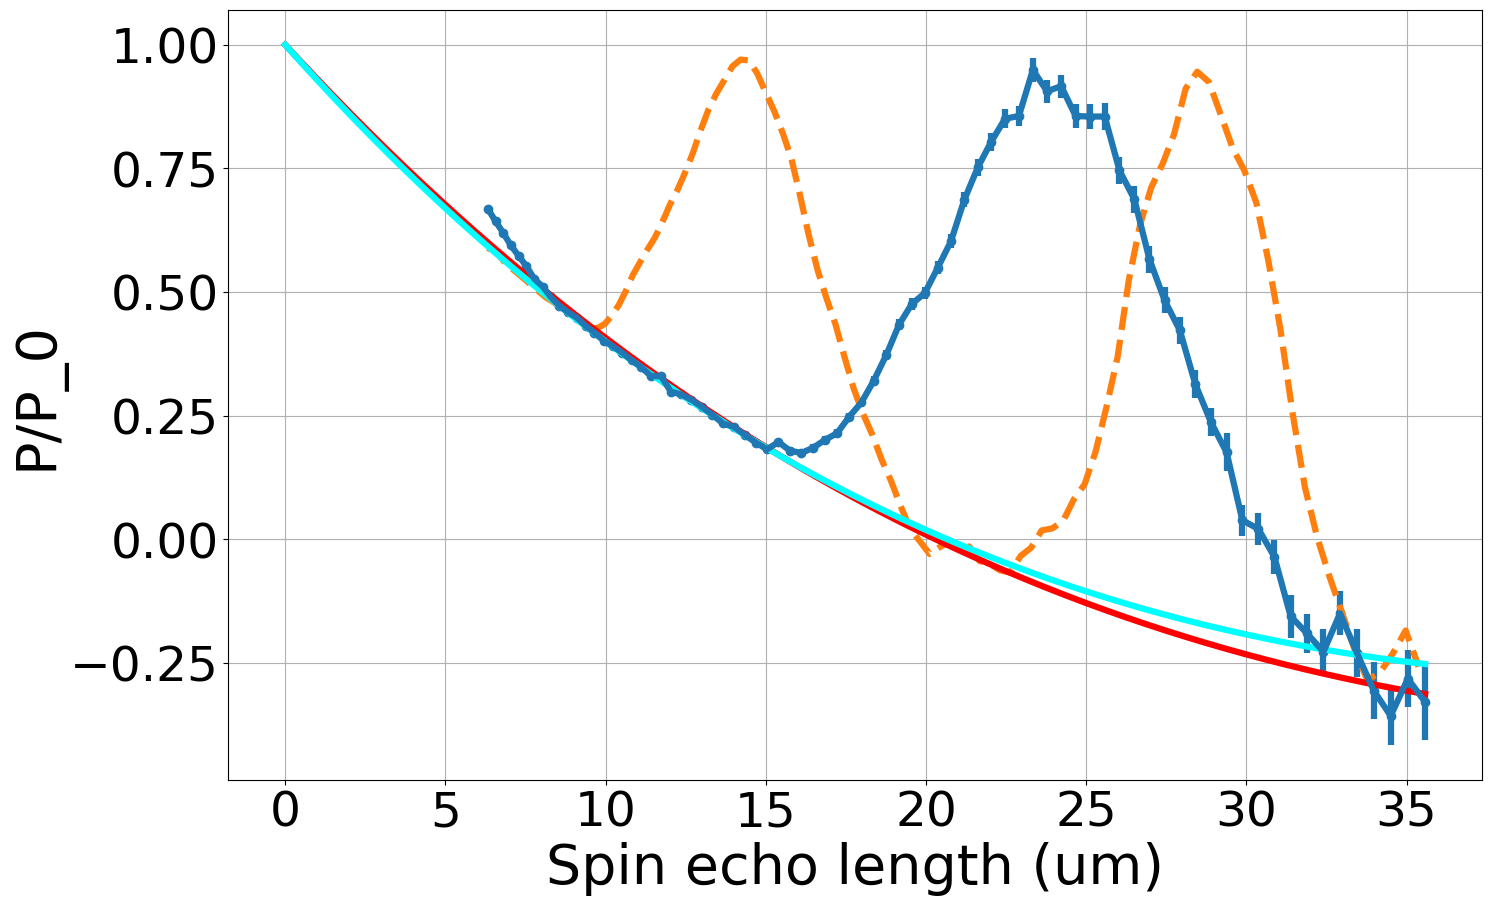

Fitted peak 0: [amp,av,sig]=[0.096 5.322 1.212]
	 Errors 0: [0.02008 0.45159 0.1935 ]
Fitted peak 1: [amp,av,sig]=[ 1.028 24.269  3.541]
	 Errors 1: [0.00926 0.03672 0.03736]


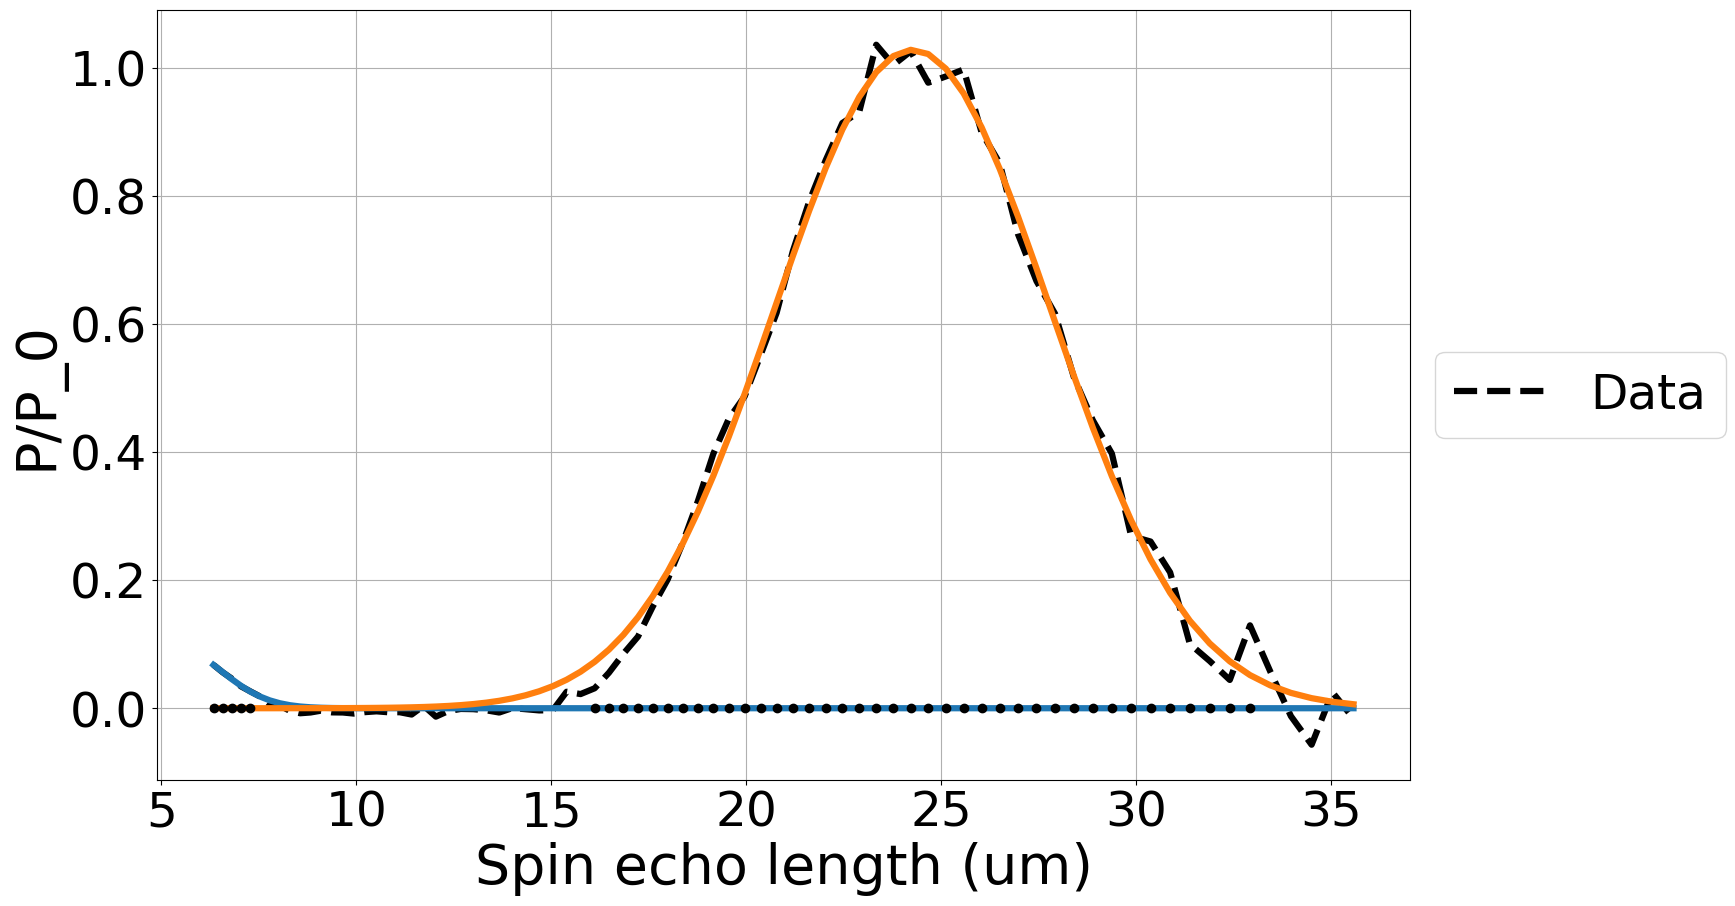

In [25]:
path = work_path
file = "pols_3Mhz_4p5deg5.5_0.1_13.25.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-1]
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)

    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])

    s = savgol_filter(y,7,3)

fig, ax = plt.subplots()
plt.plot(x,y,'o',label='Data',color='C0')
plt.errorbar(x,y,e,color='C0')
plt.plot(X3_saved,S3_saved,'--',label='3MHz,8deg',color='C1')

bs = [0.69, BG_parms_2_90[1]*np.sqrt(2/3)]  #total guess for the fit
plt.plot(x_tot,BG(x_tot,*bs),color='red',label='BG (4p5deg,3MHz)')

plt.plot(x_tot,BG(x_tot,*[.64,Rob_3]),'-',color='cyan',label='BG fit Rob')

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
plt.grid()
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig, ax = plt.subplots()
subtracted = y-BG(x,*bs)
peak_x = np.where(subtracted>0.025)
plt.plot(x,subtracted,'--',color='black',label='Data')

seperated = splitter(peak_x[0],1)

fparms = []
for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [1,x[sep[indx]],3.6]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors {indx}: {np.round(np.sqrt(np.diag(errs)),5)}')
fparms = np.array(fparms)

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
plt.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

X4_saved = np.copy(x)
X4_tot_saved = np.copy(x_tot)
S4_saved = np.copy(s)
fparms4_saved = np.copy(fparms)
BG_parms_3_4p5 = np.copy(bs)

***
# 90 deg at 3 MHz
***

a = 2163 A^-1 at rf freq 3 MHz
Cosine freq 0.46512 um^(-1/2) 



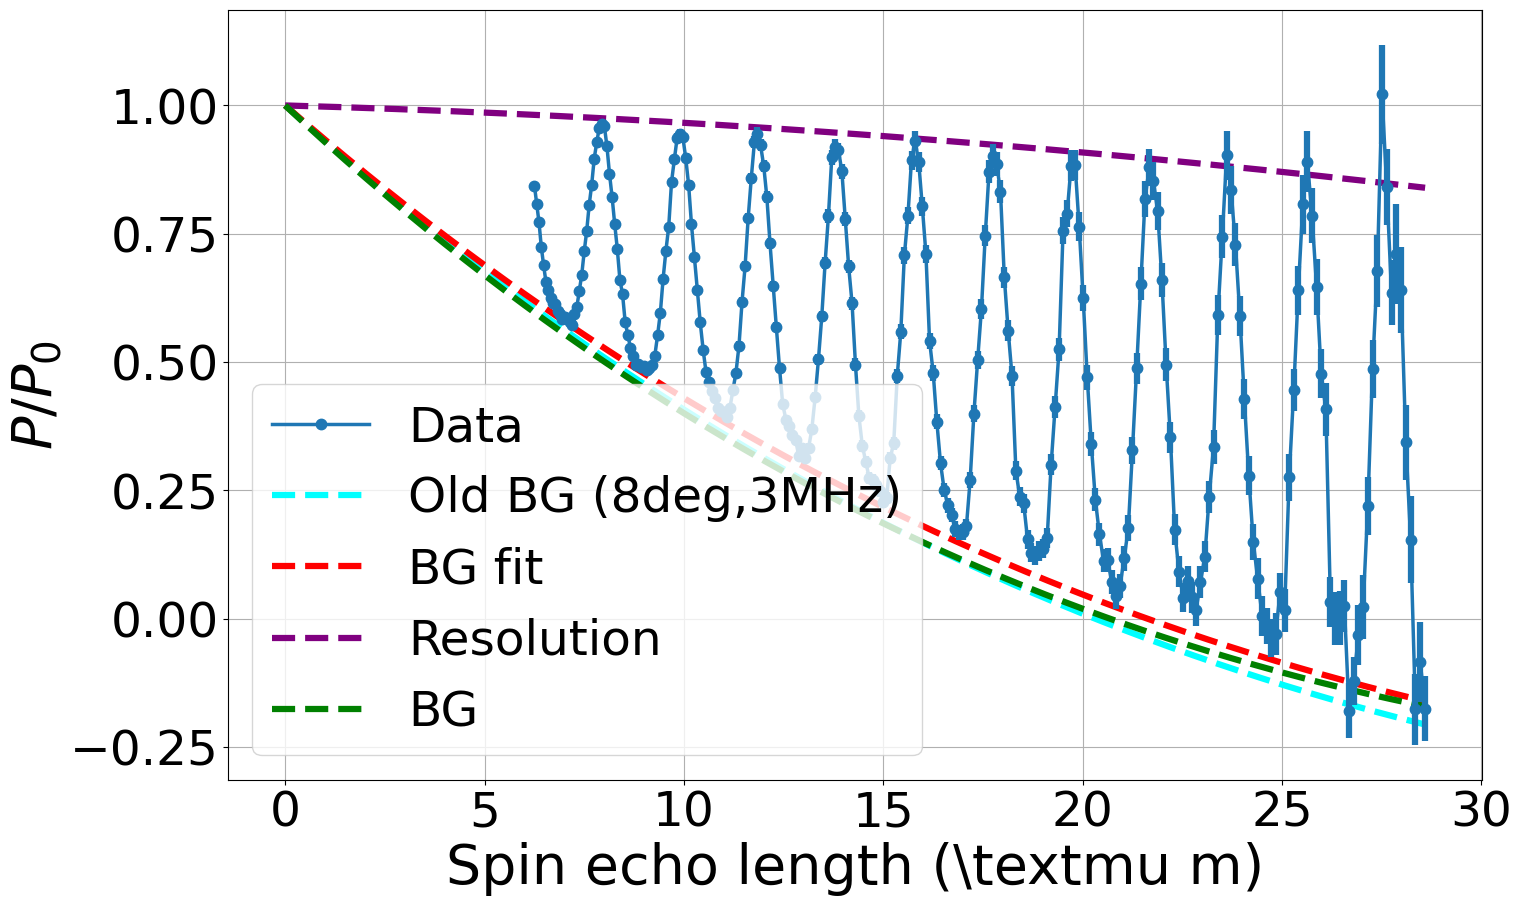

BG fit: 1 + amp*(cos(sqrt(freq)) - 1), [amp,freq]=[0.62235 0.46421]
	 Errs: [0.01876 0.00911]
Peak fit: 1-a*x**2-b*x: [a,b]=[0.00006 0.00416]
	 Errs: [0.00004 0.00054]
--------------------------------------------------

12
Fitted peak 0: [amp,av,sig]=[0.453 7.947 0.335]
	 Errors: [0.00341 0.00292 0.00325]
Fitted peak 1: [amp,av,sig]=[0.536 9.924 0.343]
	 Errors: [0.00596 0.0044  0.00464]
Fitted peak 2: [amp,av,sig]=[ 0.62  11.882  0.342]
	 Errors: [0.00854 0.00544 0.00568]
Fitted peak 3: [amp,av,sig]=[ 0.687 13.848  0.339]
	 Errors: [0.0073  0.00415 0.00441]
Fitted peak 4: [amp,av,sig]=[ 0.748 15.818  0.344]
	 Errors: [0.0143  0.0076  0.00793]
Fitted peak 5: [amp,av,sig]=[ 0.806 17.788  0.356]
	 Errors: [0.01542 0.00789 0.00843]
Fitted peak 6: [amp,av,sig]=[ 0.845 19.748  0.346]
	 Errors: [0.01795 0.00847 0.00855]
Fitted peak 7: [amp,av,sig]=[ 0.909 21.735  0.352]
	 Errors: [0.01845 0.00824 0.00849]
Fitted peak 8: [amp,av,sig]=[ 0.922 23.688  0.35 ]
	 Errors: [0.02142 0.00937 0.00957]


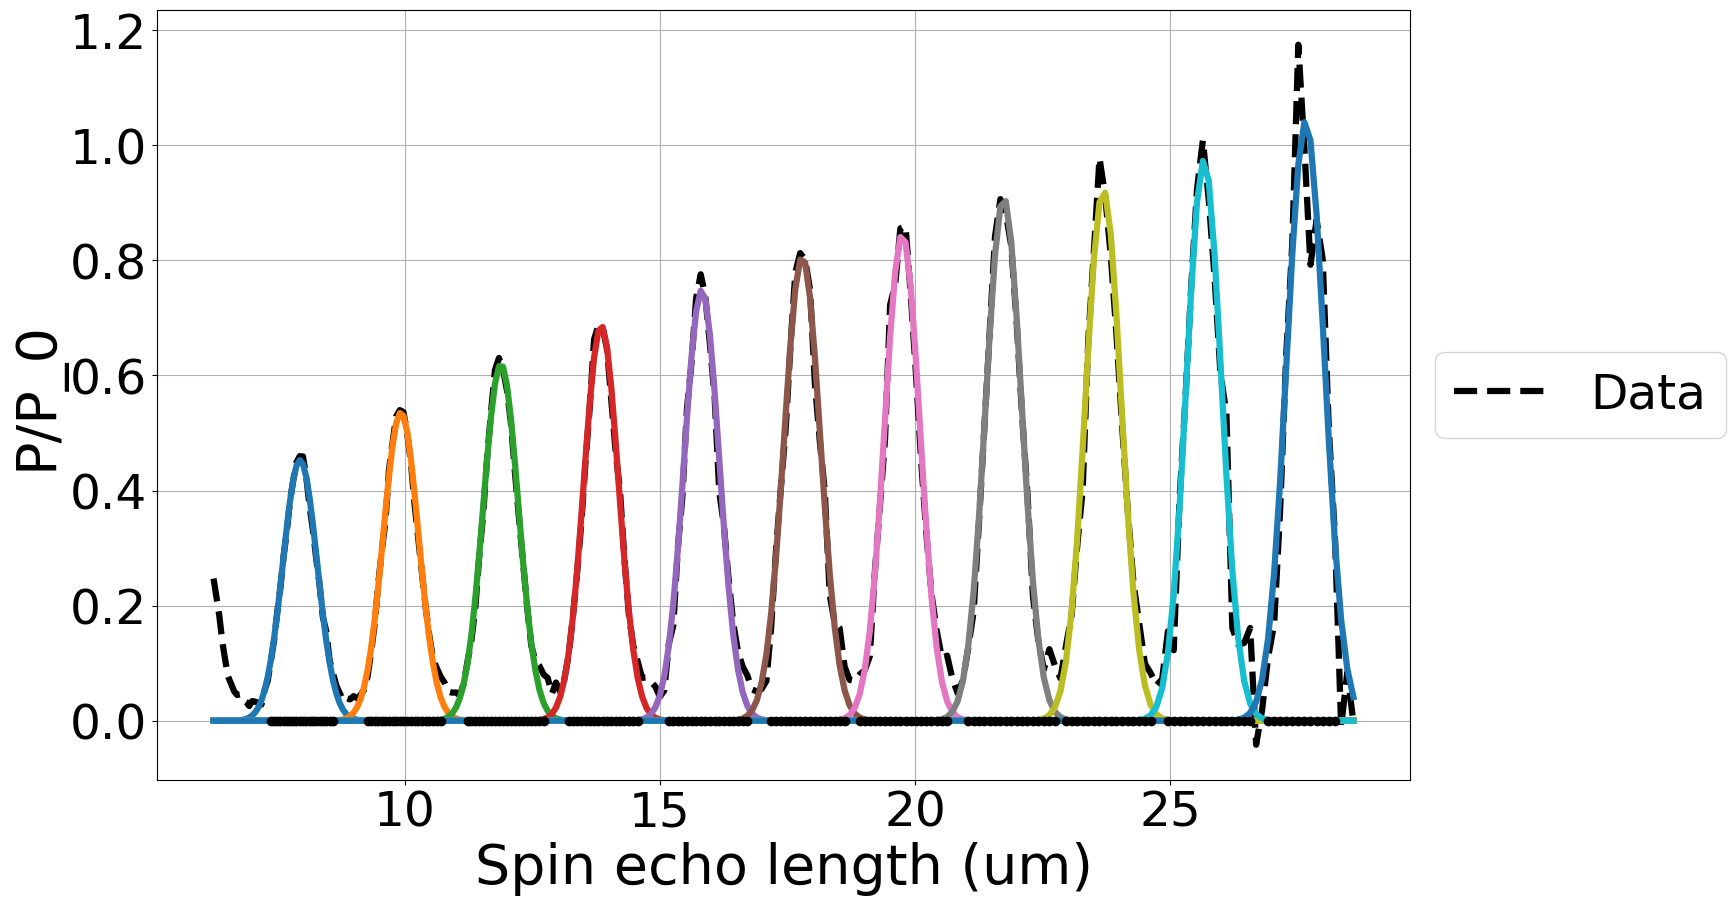

In [32]:
path = work_path
#file = "pols_3Mhz_90deg5.5_0.1_13.25.dat"
#file = "pols_3Mhz_90deg5.5_0.05_13.25.dat" #last peak at -29
file = "pols_3Mhz_90deg5.5_0.025_13.25.dat"

with open(path+file) as f:
    temp = f.readlines()[2:-58]  #-58 to include last peak, -76 otherwise
    temp = [l.replace('\n','').split(',') for l in temp]
    x = np.array([float(temp[x][0]) for x in range(len(temp))])/1e3
    x_tot = np.linspace(0,x[-1],400)
    y = np.array([float(temp[y][1]) for y in range(len(temp))])
    e = np.array([float(temp[y][2]) for y in range(len(temp))])
    s = savgol_filter(y,5,3)
    
    tr2,_ = find_peaks(-s,distance=5)
    pk2,_ = find_peaks(s,distance=15)

fig, ax = plt.subplots()
plt.plot(x,y,'o',label='Data',color='C0',ms=7.5,zorder=5,ls='-',linewidth=2.5)
plt.errorbar(x,y,e,color='C0',ls='none',zorder=5)
#plt.plot(x,s,'-',label='Data smoothed',color='C1')
#plt.plot(x[tr2],s[tr2],'o',ms=10,color='red',zorder=5)
#plt.plot(x[pk2],s[pk2],'o',ms=10,color='green',zorder=5)

guess_tr2 = [.65,get_BG_freq(3,40)[1]]  #sqrt spin echo length cosine
lb = [0,0]
ub = [1,1]
parms_tr2,err_tr2 = curve_fit(BG,x[tr2],s[tr2],p0=guess_tr2,bounds=(lb,ub),sigma=e[tr2])

guess_pk2 = [0,0]  #quad fit
parms_pk2,err_pk2 = curve_fit(quad,x[pk2],s[pk2],sigma=e[pk2])

#plt.plot(x_tot,BG(x_tot,*parms_tr2),'--',color='red',label='BG fit')
#plt.plot(x_tot,quad(x_tot,*parms_pk2),'--',color='green',label='Peak fit')
plt.plot(x_tot,BG(x_tot,*BG_parms_3_8),'--',color='cyan',label='Old BG (8deg,3MHz)')
plt.plot(x_tot,BG(x_tot,BG_parms_2_90[0],np.sqrt(2/3)*parms_tr[1]),'--',color='red',label='BG fit')
plt.plot(x_tot,np.ones(len(x_tot))-0.00218*x_tot-0.00012*x_tot**2,'--',color='purple',label='Resolution')

plt.plot(x_tot,BG(x_tot,*[.64,Rob_3]),'--',color='green',label='BG')

#plt.title('3MHz 90 deg')
ax.legend(loc='lower left')#, bbox_to_anchor=(1, 0.5))
plt.xlabel(r'Spin echo length (\textmu m)')
plt.ylabel(r'$P/P_0$')
#ax.set_xticks(range(4,30,2))
plt.grid()
plt.show()

print(f'BG fit: 1 + amp*(cos(sqrt(freq)) - 1), [amp,freq]={np.round(parms_tr2,5)}')
print(f'\t Errs: {np.round(np.sqrt(np.diag(err_tr2)),5)}')
print(f'Peak fit: 1-a*x**2-b*x: [a,b]={np.round(parms_pk2,5)}')
print(f'\t Errs: {np.round(np.sqrt(np.diag(err_pk2)),5)}')
print('-'*50 + '\n')

fig, ax = plt.subplots()
#subtracted = y-BG(x,*parms_tr2)
#subtracted = y - BG(x,BG_parms_2_90[0],np.sqrt(2/3)*parms_tr[1])
#subtracted = y-BG(x,*BG_parms_3_8)
subtracted = y-BG(x,*[.64,Rob_3])

peak_x = np.where(subtracted>0.075)
plt.plot(x,subtracted,'--',color='black',label='Data')

seperated = splitter(peak_x[0],1)[1:]

fparms = []
all_errs2 = []
print(len(sep))

for indx,sep in enumerate(seperated):
    plt.plot(x[sep],np.zeros(len(sep)),'o',color='black',zorder=10)  #peak fit domain
    
    guess = [.5,x[sep[len(sep)//2]],.35]
    ff,errs = curve_fit(ampgauss,x[sep],subtracted[sep],p0=guess)
    fparms.append(ff)
    all_errs2.append(errs)
    #plt.plot(x,ampgauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(x,ampgauss(x,*ff),color=f'C{indx}')
    
    print(f'Fitted peak {indx}: [amp,av,sig]={np.round(ff,3)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(errs)),5)}')

plt.xlabel('Spin echo length (um)')
plt.ylabel('P/P_0')
plt.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

X5_saved = np.copy(x)
X5_tot_saved = np.copy(x_tot)
S5_saved = np.copy(s)
fparms5_saved = np.copy(fparms)
BG_parms_3_90 = np.copy(parms_tr2)

***
# Peak width comparison
***

Slope,intercept of peak standard deviations (2MHz): [0.0022  0.30606]
	 Errors (2MHz): [0.00042 0.00388]
Slope,intercept of peak standard deviations (3MHz): [0.00099 0.32858]
	 Errors (3MHz): [0.00025 0.00339]
Slope,intercept of peak standard deviations (2MHz and 3MHz): [0.00213 0.30892]
	 Errors (2MHz and 3MHz): [0.00031 0.00329]


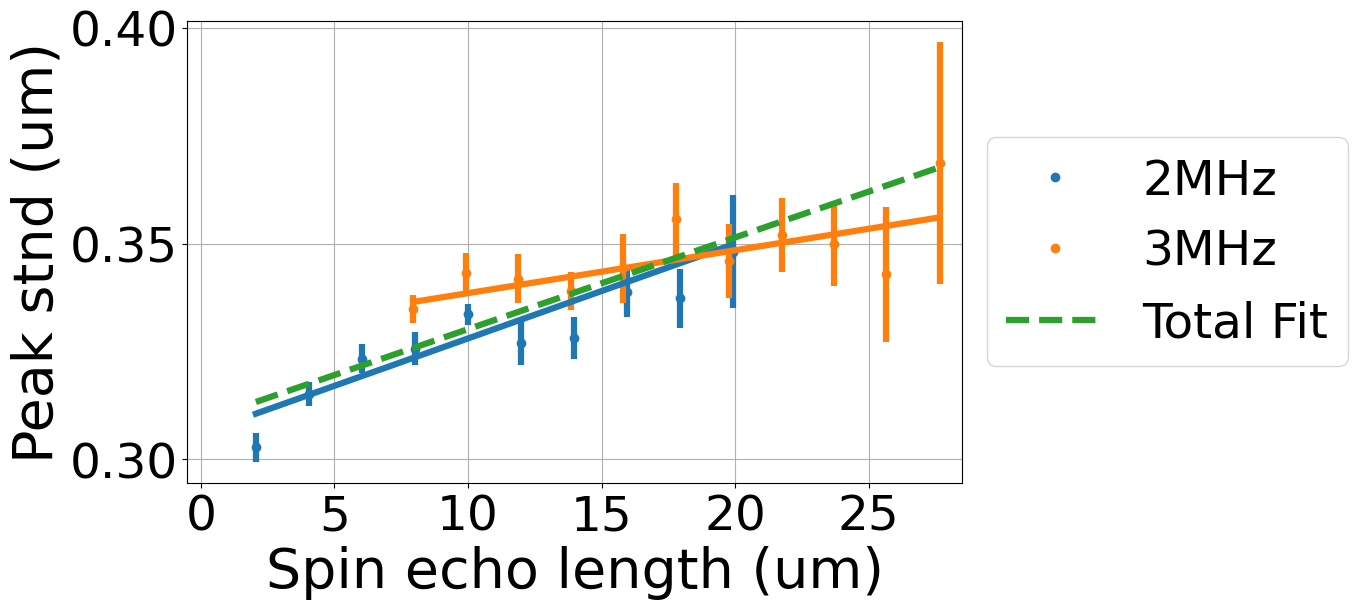

In [27]:
peak_pos = fparms_saved[:,1]
peak_sig = fparms_saved[:,2]
peak_pos2 = fparms2_saved[:,1]
peak_sig2 = fparms2_saved[:,2]
peak_pos3 = fparms3_saved[:,1]
peak_sig3 = fparms3_saved[:,2]
peak_pos4 = fparms4_saved[:,1]
peak_sig4 = fparms4_saved[:,2]
peak_pos5 = fparms5_saved[:,1]
peak_sig5 = fparms5_saved[:,2]

fig, ax = plt.subplots(figsize=(10,6))
all_poses = np.concatenate((peak_pos,peak_pos5))
all_sigs = np.concatenate((peak_sig,peak_sig5))

really_all_errs = np.concatenate((np.array([np.sqrt(np.diag(e)) for e in all_errs])[:,2],\
                                  np.array([np.sqrt(np.diag(e)) for e in all_errs2])[:,2]))
all_poses, all_sigs, really_all_errs = zip(*sorted(zip(all_poses, all_sigs, really_all_errs)))
all_poses, all_sigs, really_all_errs = np.array(all_poses), np.array(all_sigs), np.array(really_all_errs)

spread1,spread1_err = curve_fit(line,peak_pos,peak_sig,sigma=\
                                np.array([np.sqrt(np.diag(e)) for e in all_errs])[:,2])  #only 2 MHz data
print(f'Slope,intercept of peak standard deviations (2MHz): {np.round(spread1,5)}')
print(f'\t Errors (2MHz): {np.round(np.sqrt(np.diag(spread1_err)),5)}')

spread2,spread2_err = curve_fit(line,peak_pos5,peak_sig5,sigma=\
                                np.array([np.sqrt(np.diag(e)) for e in all_errs2])[:,2])  #only 2 MHz data
print(f'Slope,intercept of peak standard deviations (3MHz): {np.round(spread2,5)}')
print(f'\t Errors (3MHz): {np.round(np.sqrt(np.diag(spread2_err)),5)}')

spread,spread_err = curve_fit(line,all_poses,all_sigs,sigma=really_all_errs)  #both 2 and 3 MHz
print(f'Slope,intercept of peak standard deviations (2MHz and 3MHz): {np.round(spread,5)}')
print(f'\t Errors (2MHz and 3MHz): {np.round(np.sqrt(np.diag(spread_err)),5)}')

zero_se_sig = spread[1]  #zero spin echo width from linear fit
zero_se_sig_saved = zero_se_sig

#qspread1,qspread1_err = curve_fit(mod_quad,peak_pos,peak_sig)
#print(f'ax^2+bx+c of peak standard deviations: {np.round(qspread1,5)}')
#print(f'\t Errors: {np.round(np.sqrt(np.diag(qspread1_err)),5)}')

plt.plot(peak_pos,peak_sig,'o',label='2MHz',color='C0')
plt.errorbar(peak_pos,peak_sig,np.array([np.sqrt(np.diag(e)) for e in all_errs])[:,2],color='C0',ls='none')
plt.plot(peak_pos5,peak_sig5,'o',label='3MHz',color='C1')
plt.errorbar(peak_pos5,peak_sig5,np.array([np.sqrt(np.diag(e)) for e in all_errs2])[:,2],color='C1',ls='none')

#plt.axhline(y=1.44/np.sqrt(24),color='black',label='Ideal')
plt.plot(peak_pos,line(peak_pos,*spread1),'-',color='C0')
plt.plot(peak_pos5,line(peak_pos5,*spread2),'-',color='C1')
plt.plot(all_poses,line(all_poses,*spread),'--',label='Total Fit',color='C2')
#plt.plot(peak_pos,mod_quad(peak_pos,*qspread1),'--',label='Quad fit',color='C3')

plt.xlim([-.5, 28.5])
plt.xlabel('Spin echo length (um)')
plt.ylabel('Peak stnd (um)')
ax.set_xticks([0.,5.,10.,15.,20.,25.])
plt.grid()
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

if False:
    print(f'{"-"*10}2 MHz 90 deg{"-"*10} \n {np.round(fparms_saved,5)}')
    print(f'{"-"*10}2 MHz 8 deg{"-"*10} \n {np.round(fparms2_saved,5)}')
    print(f'{"-"*10}3 MHz 8 deg{"-"*10} \n {np.round(fparms3_saved,5)}')
    print(f'{"-"*10}3 MHz 4.5 deg{"-"*10} \n {np.round(fparms4_saved,5)}')
    print(f'{"-"*10}3 MHz 90 deg{"-"*10} \n {np.round(fparms5_saved,5)} \n')

if False:
    print(f'Width comparison factors using effective zero spin echo length peak width:')
    print(f'\t 2 MHz at 8 deg: {round(peak_sig2[1]/zero_se_sig,5)}')
    print(f'\t 3 MHz at 8 deg: {np.round(peak_sig3/zero_se_sig,5)}')
    print(f'\t 3 MHz at 4.5 deg: {round(peak_sig4[1]/zero_se_sig,5)}')
    print(f'\t 3 MHz at 90 deg: {np.round(peak_sig5/zero_se_sig,5)} \n')

if False:
    print(f'Peak position increase factors using fitted 1st peak position at 2 MHz, 90 deg:')
    print(f'\t 2 MHz at 8 deg: {round(peak_pos2[1]/peak_pos[0],5)}')
    print(f'\t 3 MHz at 8 deg: {np.round(peak_pos3/peak_pos[0],5)}')
    print(f'\t 3 MHz at 4.5 deg: {round(peak_pos4[1]/peak_pos[0],5)}')
    print(f'\t 3 MHz at 90 deg: {np.round(peak_pos5/peak_pos[3],5)} \n') #compare same order

if False:
    print(f'Ratios (width/position):')
    print(f'\t 2 MHz at 8 deg: {round(peak_sig2[1]/zero_se_sig/(peak_pos2[1]/peak_pos[0]),5)}')
    print(f'\t 3 MHz at 8 deg: {np.round(peak_sig3/zero_se_sig/(peak_pos3[0]/peak_pos[0]),5)}')
    print(f'\t 3 MHz at 4.5 deg: {round(peak_sig4[1]/zero_se_sig/(peak_pos4[1]/peak_pos[0]),5)}')
    print(f'\t 3 MHz at 90 deg: {np.round(peak_sig5/zero_se_sig/(peak_pos5[0]/peak_pos[3]),5)} \n')

Saved:
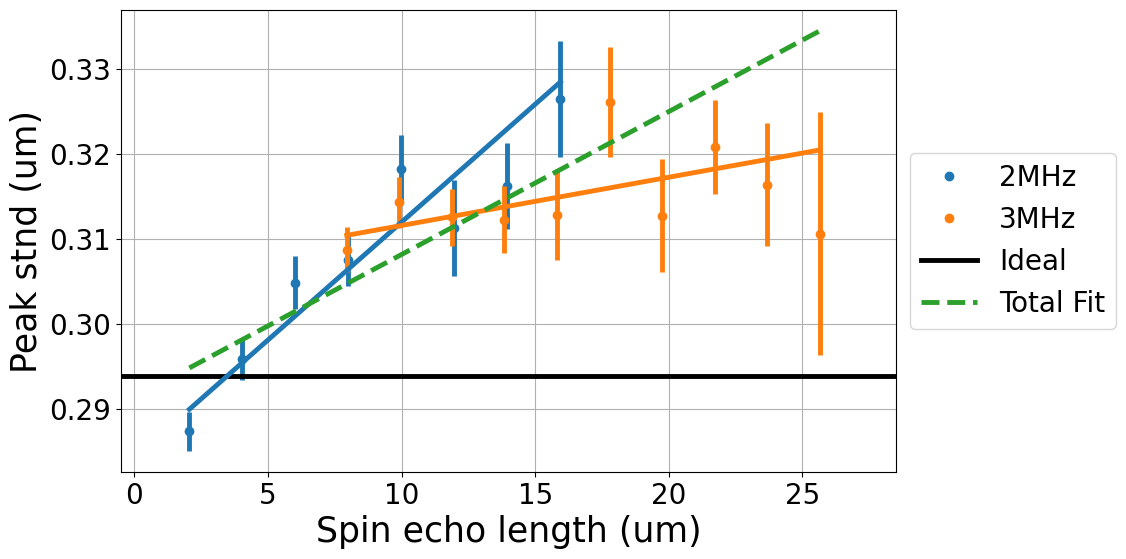

Saved:
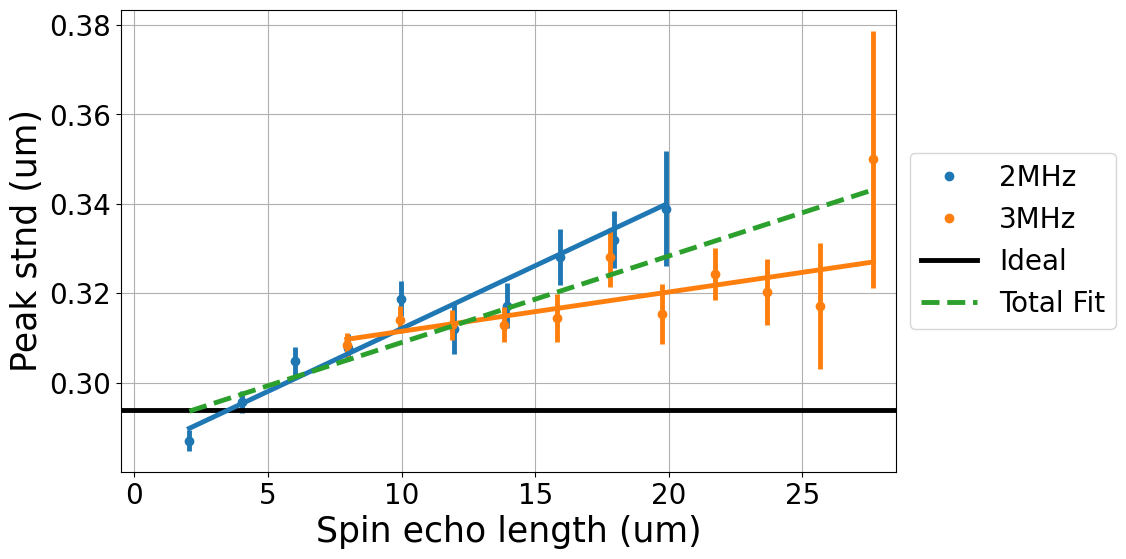

### Excess width

Zero spin echo stnd (theory): 0.29394 

Zero spin echo stnd (fitted): 0.29138 

Excesses: [-0.00380892  0.00113274  0.00654323  0.00818283  0.01487861  0.01048867
  0.01358729  0.02015995  0.00892223  0.01239689  0.0112723   0.01110959
  0.01147128  0.01993153  0.01139834  0.01651421  0.01368819  0.01008673] 

Widths: [0.00143639 0.00158137 0.00197859 0.00171093 0.00194996 0.0019762
 0.00257443 0.00214925 0.00356822 0.00251336 0.00323672 0.00337884
 0.00449715 0.00428922 0.00417164 0.00359667 0.00462316 0.00888049] 

Linear fit a*x: [a] = [0.00089]
	 Errors: [0.00008]
Sqrt of slope: 0.02979


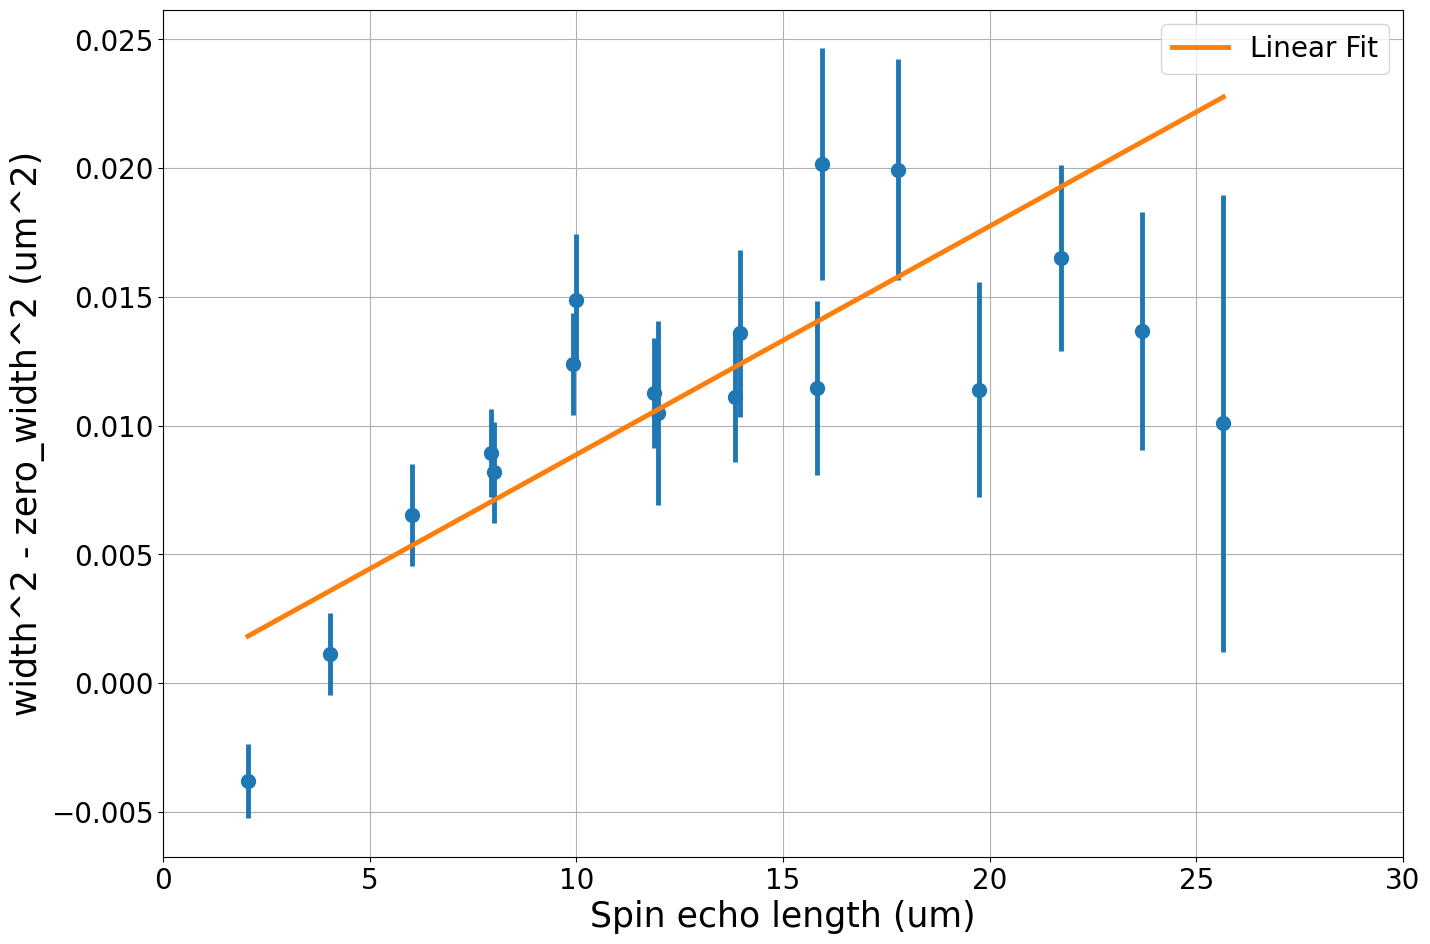

In [116]:
zero_se_sig = zero_se_sig_saved
zero_se_sig = 1.44/np.sqrt(24)  #standard deviation of triangular distribution
print(f'Zero spin echo stnd (theory): {round(zero_se_sig,5)} \n')
print(f'Zero spin echo stnd (fitted): {round(zero_se_sig_saved,5)} \n')

def sqrt_ex(x,a):
    return a*np.sqrt(x)
def log_ex(x,a):
    return a*np.log(x+1)
def line_ex(x,a):
    return a*x

excess = (peak_sig**2 - zero_se_sig**2)
excess2 = (peak_sig5**2 - zero_se_sig**2)

all_sigs = np.concatenate((peak_sig,peak_sig5))
all_poses = np.concatenate((peak_pos,peak_pos5))
all_excess = np.concatenate((excess,excess2))
print(f'Excesses: {all_excess} \n')

all_poses, all_excess, all_sigs = zip(*sorted(zip(all_poses, all_excess, all_sigs)))
all_poses, all_excess, all_sigs = np.array(all_poses), np.array(all_excess), np.array(all_sigs)

#need to check this formula...
sig_g = 2*np.sqrt([(all_sigs[i]*really_all_errs[i])**2 + \
                 (zero_se_sig*.001)**2 for i in range(len(all_excess))])
print(f'Widths: {sig_g} \n')

plt.plot(all_poses,all_excess,'o',ms=10)
plt.errorbar(all_poses,all_excess,sig_g,ls='None',color='C0')

if False:
    fitted,pcov = curve_fit(sqrt_ex,all_poses,all_excess,sigma=sig_g)
    print(f'Sqrt fit a*sqrt(x): [a] = {np.round(fitted,5)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(pcov)),5)}')
    plt.plot(all_poses,sqrt_ex(all_poses,*fitted),'-',label='Sqrt Fit')

if False:
    fitted,pcov = curve_fit(log_ex,all_poses,all_excess,sigma=sig_g)
    print(f'Log fit a*log(x+1): [a] = {np.round(fitted,5)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(pcov)),5)}')
    plt.plot(all_poses,log_ex(all_poses,*fitted),'-',label='Log Fit')

if True:
    fitted,pcov = curve_fit(line_ex,all_poses,all_excess,sigma=sig_g)
    print(f'Linear fit a*x: [a] = {np.round(fitted,5)}')
    print(f'\t Errors: {np.round(np.sqrt(np.diag(pcov)),5)}')
    plt.plot(all_poses,line_ex(all_poses,*fitted),'-',label='Linear Fit')
    print(f'Sqrt of slope: {round(np.sqrt(fitted[0]),5)}')

plt.xlabel('Spin echo length (um)')
plt.ylabel('width^2 - zero_width^2 (um^2)')
plt.xlim([0, 30])
ax.set_xticks([0.,5.,10.,15.,20.,25.,30.])
plt.legend()
plt.grid()
plt.show()

***
# Convolution testing
***

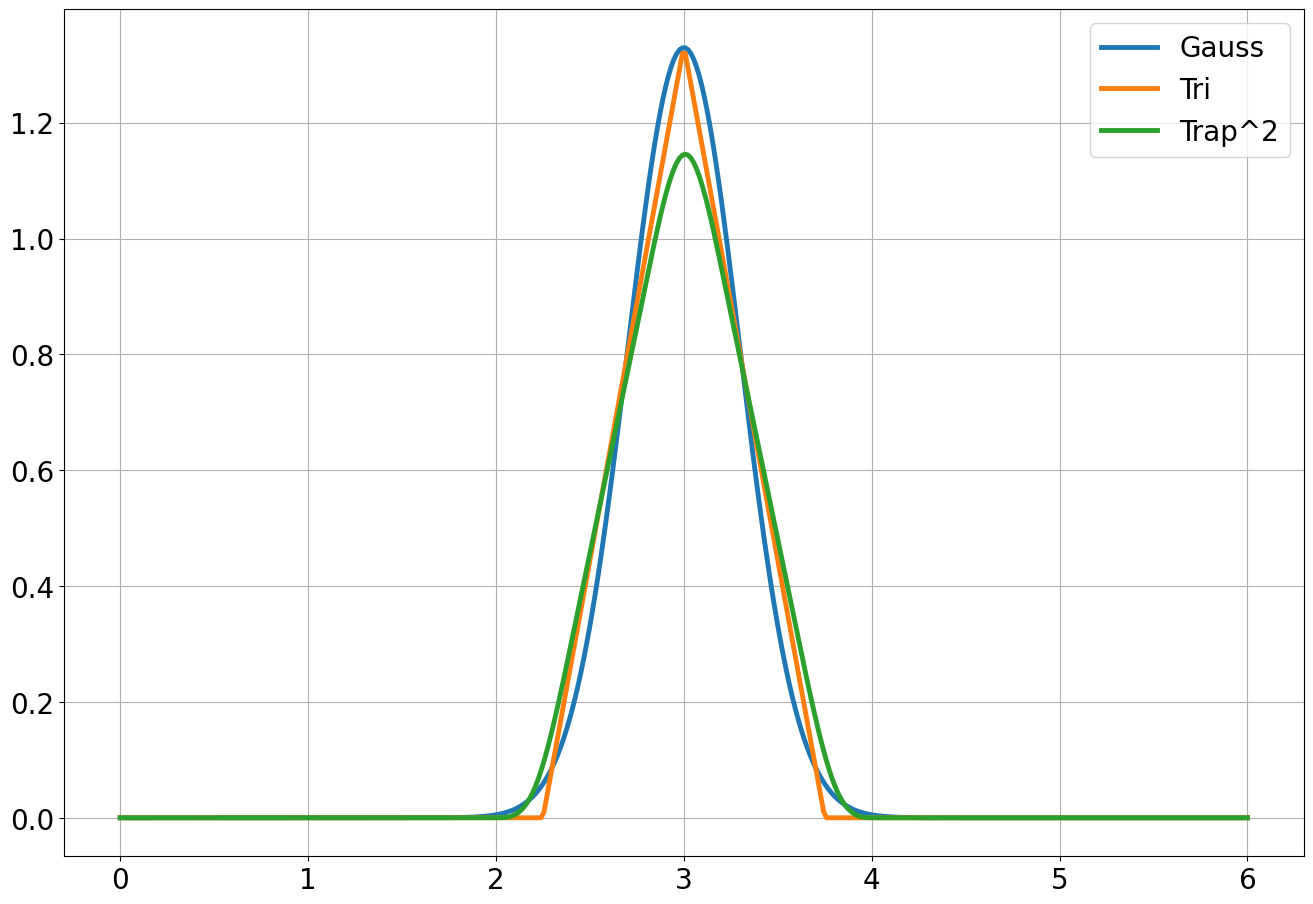

In [153]:
def tri(x,parms):
    if len(parms)==2:
        mn,mx = parms
        md = (mx+mn)/2 #symmetric case
    else:
        mn,md,mx = parms
        
    output = []
    for val in x:
        if val<mn: output.append(0)
        elif val<md:
            temp = 2*(val-mn)/((mx-mn)*(md-mn))
            output.append(temp)
        elif val<mx:
            temp = 2*(mx-val)/((mx-mn)*(mx-md))
            output.append(temp)
        else: output.append(0)
    return output

def sqr(x,parms):
    a,b = parms
    output = []
    for val in x:
        if val<a: output.append(0)
        elif val<b: output.append(1)
        else: output.append(0)
    return output/simpson(output,x)

def trap(x,parms):
    a,b,c,d = parms
    output = []
    for val in x:
        if val<a: output.append(0)
        elif val<b:
            temp = 2/(d+c-a-b)*(val-a)/(b-a)
            output.append(temp)
        elif val<c:
            temp = 2/(d+c-a-b)
            output.append(temp)
        elif val<d:
            temp = 2/(d+c-a-b)*(d-val)/(d-c)
            output.append(temp)
        else: output.append(0)
    return output

x_temp = np.linspace(0,6,400)
gp = [3,.3]
plt.plot(x_temp,gauss(x_temp,*gp),label='Gauss')

trip = [2.25,3,3.75]
plt.plot(x_temp,tri(x_temp,trip),label='Tri')

trapp = [2.5,2.7,3.3,3.5]
c_trap = convolve(trap(x_temp,trapp),trap(x_temp,trapp),mode='same')
c_trap = c_trap/simpson(c_trap,x=x_temp)
plt.plot(x_temp,c_trap,label='Trap^2')

plt.legend()
plt.grid()
plt.show()